# Simple model inversion

### Getting started

First, install the required modules:

In [1]:
!pip install numpy matplotlib opencv-python tensorflow

### Init

It's okay if you cannot get GPU support, the model and the training data is small enough to run on CPU.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import time
#GPU test and settings
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TRAINDIR = 'faces/train' # directory where we store our data
TESTDIR = 'faces/test' # directory where we store our testing data
IMG_Y_SIZE = 112
IMG_X_SIZE = 92
names = os.listdir(TRAINDIR) # list of classes i.e. names
NUM_NAMES = len(names)


Num GPUs Available:  0


### Load data

In [13]:
# load the training data

training_data = []

for name in names:
    name_num = names.index(name)
    for img in os.listdir(f"{TRAINDIR}/{name}"):
        img_array = cv2.imread(f"{TRAINDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
        new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
        training_data.append([new_array, name_num]) # add it to training_data along with its name


random.shuffle(training_data) # randomize the training data (make learning more effective)

# prepare the training data for ML i.e. convert to numpy
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,IMG_X_SIZE,IMG_Y_SIZE,1)
y = np.array(y)

X = X / 255

train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(10000).batch(10)

print(X.shape, y.shape, train_ds.cardinality().numpy())
    

(360, 92, 112, 1) (360,) 36


In [14]:
# load the testing data

testing_data = []

for name in names:
    name_num = names.index(name)
    for img in os.listdir(f"{TESTDIR}/{name}"):
        img_array = cv2.imread(f"{TESTDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
        new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
        testing_data.append([new_array, name_num]) # add it to testing_data along with its name

XT = []
yt = []

for features, label in testing_data:
    XT.append(features)
    yt.append(label)
    

XT = np.array(XT).reshape(-1,IMG_X_SIZE,IMG_Y_SIZE,1)
yt = np.array(yt)

XT = XT / 255

test_ds = tf.data.Dataset.from_tensor_slices((XT, yt)).batch(10)

print(XT.shape, yt.shape, test_ds.cardinality().numpy())


(40, 92, 112, 1) (40,) 4


### Train model

This will train the target face recognition model which we will use to try reconstruction of the training data

In [15]:
NAME = "Face-Recognition-CNN-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

model= Sequential([
    Input((IMG_X_SIZE,IMG_Y_SIZE, 1)),
    Conv2D(filters=36, kernel_size=7, activation='relu'),
    Flatten(),
    Dense(NUM_NAMES, activation='softmax')  
])

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 86, 106, 36)    │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 328176)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │    13,127,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,128,880 (50.08 MB)

 Trainable params: 13,128,880 (50.08 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# train the model
model.fit(X, y, batch_size=40, epochs=20, callbacks = [tensorboard])

# to view tensorboard, go to terminal and type tensorboard --logdir='logs/'

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0452 - loss: 15.6368
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.2643 - loss: 3.3923
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8149 - loss: 1.2020
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9588 - loss: 0.2367
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9936 - loss: 0.1138
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9979 - loss: 0.0341
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9994 - loss: 0.0087
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0049
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0011


### Reconstruct images

You can try experimenting with:

* The learning rate
* The number of iterations for each image
* The scale of noise added at each iteration
* Starting with noise instead of black image

although this is the best setup I could come up with

Decoding:  s1


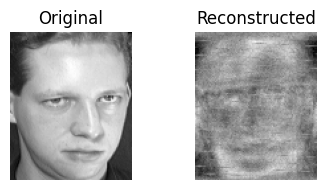

Decoding:  s10


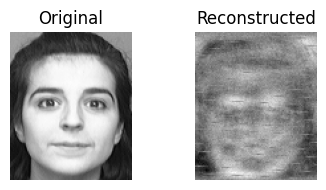

Decoding:  s11


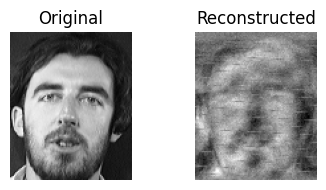

Decoding:  s12


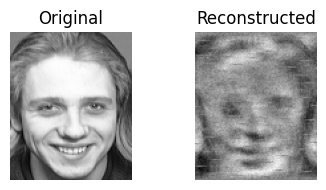

Decoding:  s13


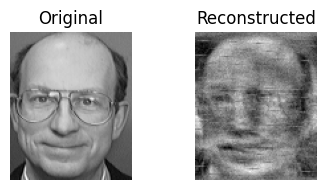

Decoding:  s14


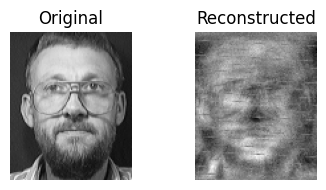

Decoding:  s15


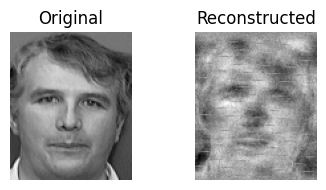

Decoding:  s16


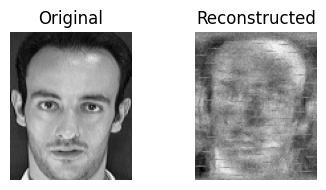

Decoding:  s17


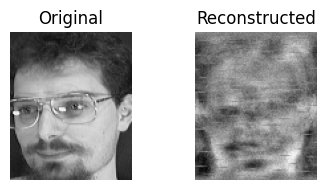

Decoding:  s18


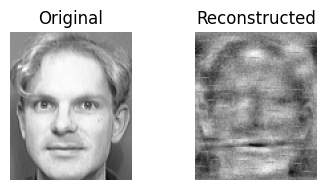

Decoding:  s19


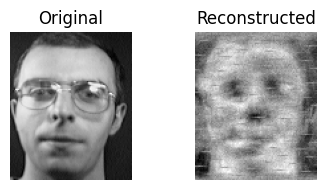

Decoding:  s2


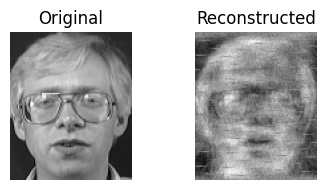

Decoding:  s20


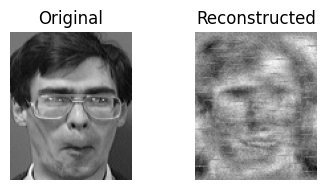

Decoding:  s21


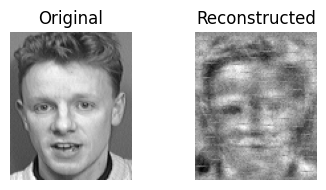

Decoding:  s22


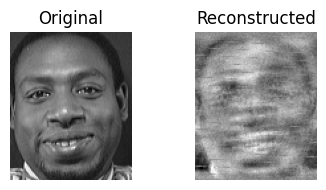

Decoding:  s23


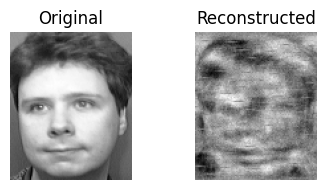

Decoding:  s24


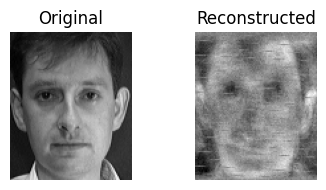

Decoding:  s25


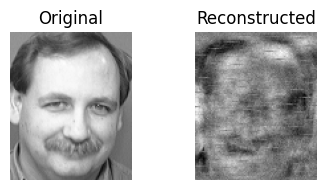

Decoding:  s26


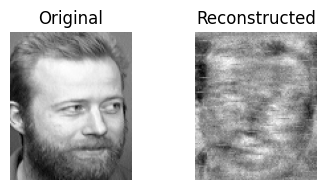

Decoding:  s27


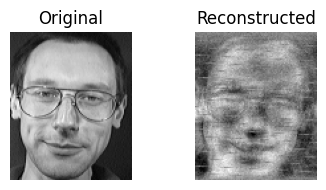

Decoding:  s28


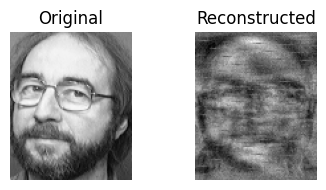

Decoding:  s29


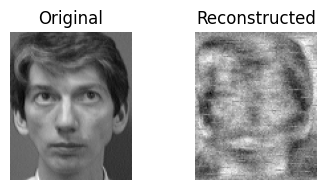

Decoding:  s3


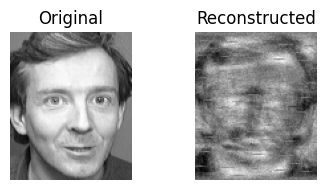

Decoding:  s30


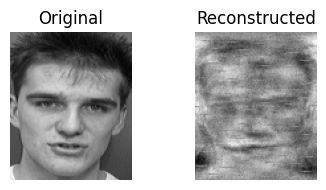

Decoding:  s31


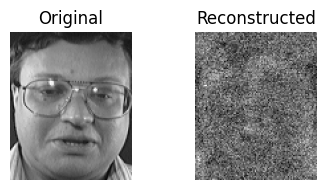

Decoding:  s32


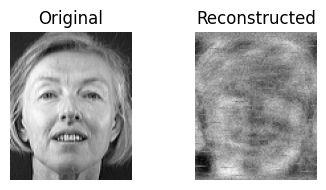

Decoding:  s33


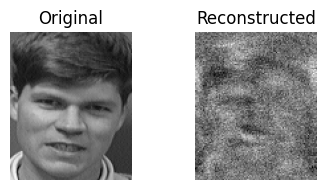

Decoding:  s34


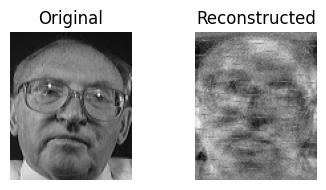

Decoding:  s35


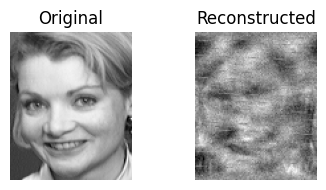

Decoding:  s36


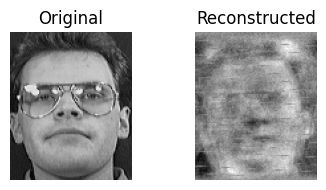

Decoding:  s37


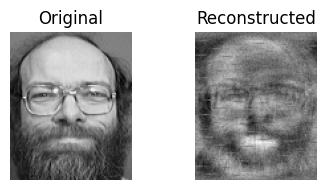

Decoding:  s38


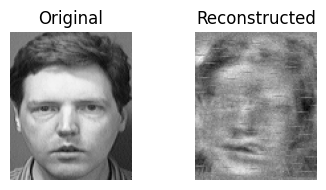

Decoding:  s39


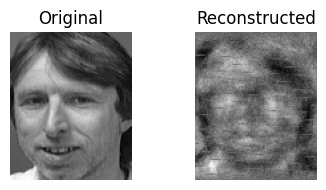

Decoding:  s4


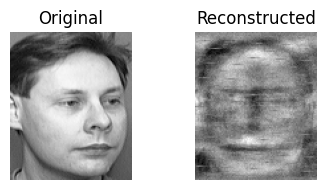

Decoding:  s40


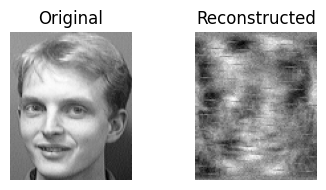

Decoding:  s5


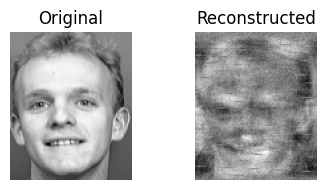

Decoding:  s6


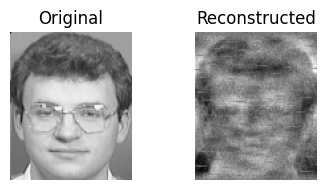

Decoding:  s7


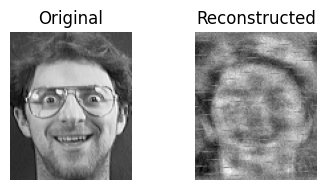

Decoding:  s8


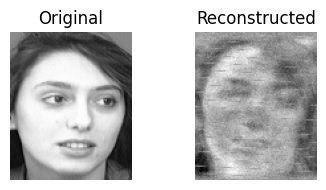

Decoding:  s9


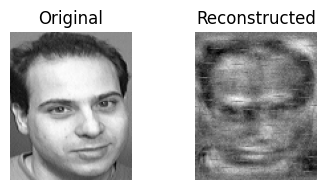

In [17]:

loss_fn = SparseCategoricalCrossentropy()
learning_rate = 0.01

for name_index in range(NUM_NAMES):
    print("Decoding: ", names[name_index])
    img = tf.convert_to_tensor(np.zeros((1,IMG_X_SIZE,IMG_Y_SIZE,1)))

    for i in range(200):
        with tf.GradientTape() as tape:
            tape.watch(img)
            prediction = model(img, training=False)
            loss = loss_fn(tf.convert_to_tensor([name_index]), prediction)
        
            gradient = tape.gradient(loss, img)
            img = tf.clip_by_value(img - learning_rate * gradient, 0, 255)

            # Add noise
            noise = np.random.normal(loc=0.01, scale=0.001, size=img.shape)
            img = np.clip(img.numpy() + noise, 0, 255)
            img = tf.convert_to_tensor(img, dtype=tf.float64)

    _, axs = plt.subplots(1, 2, figsize=(4, 2))
    axs[0].imshow(tf.reshape(XT[name_index], (IMG_Y_SIZE, IMG_X_SIZE)), cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(tf.reshape(img, (IMG_Y_SIZE, IMG_X_SIZE)), cmap='gray')
    axs[1].set_title("Reconstructed")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()